In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter as TorchParam
from torch import Tensor
from typing import List, Tuple
from joblib import parallel_backend
import optuna
from torch.jit import ScriptModule, script_method

In [3]:
MeasurementData_Merged = pd.read_csv(r"C:\20_Develop\10_Programming\60_thermal-nn\usecase\10_yuping\MeasurementData_Merged_EFAD.csv", index_col=0)
MeasurementData_Merged.head()

,nEmFild100ms.Rec_10ms_Fild.pp_rbe_CddAgEm_10ms_Fild.rbe_CddRslvr,tqEmFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,frqSlipFild10ms.Rec_2ms_Fild.pp_rbe_MctAsm_2ms_Fild.rbe_MctAsm,iDaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm,iQaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm,uDaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,uQaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,OilPmpCoolgSpdAct,OilPmpCoolgSpdReq,R_CW_vfCooltEm,...,I_EM_tTMotWinMidLay12Cl06,I_EM_tTMotWinMidLay56Cl06,I_EM_tTMotWinMidLay56Cl12,I_EM_tTMotWinNdeLay2Cl03,I_EM_tTMotWinNdeLay2Cl12,I_EM_tTMotWinNdeLay5Cl03,I_EM_tTMotWinNdeLay5Cl12,Time,profile_id,profile_name
0,0.0,0.0,0.050290,0.875000,0.062500,0.0,0.000000,2999.000000,3000.0,8.0,...,20.921059,NaN,21.653483,19.6,20.2,19.6,13.9,0.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...
1,-1.0,0.0,-0.027593,0.834663,0.000000,0.0,-0.031250,3002.000000,3000.0,8.0,...,20.917589,NaN,21.652054,19.6,20.2,19.6,13.9,0.675728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...
2,0.0,0.0,0.009212,0.750000,0.062500,0.0,-0.000006,3000.200958,3000.0,8.0,...,20.917004,NaN,21.650740,19.6,20.2,19.6,13.9,1.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...
3,0.0,0.0,-0.046306,0.812500,0.000000,0.0,-0.000017,3000.000000,3000.0,8.0,...,20.916369,NaN,21.647013,19.6,20.2,19.6,13.9,1.675728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...
4,1.0,0.0,0.074648,0.812500,0.084479,0.0,0.000000,3001.000000,3000.0,8.0,...,20.916947,NaN,21.646527,19.6,20.2,19.6,13.9,2.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...


<Axes: >

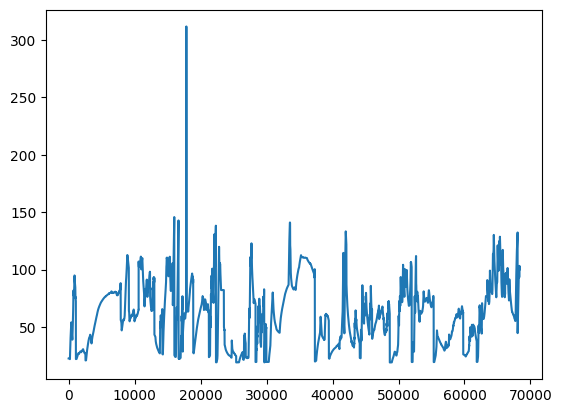

In [4]:
MeasurementData_Merged['pm'] = MeasurementData_Merged[['ExternTemp.rp_rbe_Cif_10ms_PIExternTemp1.rbe_Cif', 'ExternTemp.rp_rbe_Cif_10ms_PIExternTemp10.rbe_Cif', 'ExternTemp.rp_rbe_Cif_10ms_PIExternTemp5.rbe_Cif','ExternTemp.rp_rbe_Cif_10ms_PIExternTemp7.rbe_Cif']].mean(axis=1)
MeasurementData_Merged['pm'].plot()

<Axes: >

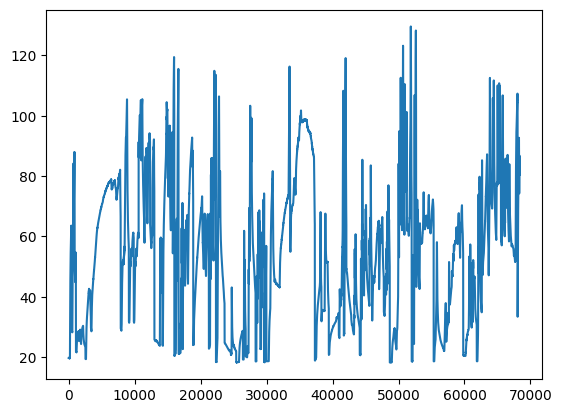

In [5]:
MeasurementData_Merged['stator_winding'] = MeasurementData_Merged[['I_EM_tTMotWinDeLay2Cl03', 'I_EM_tTMotWinDeLay2Cl12','I_EM_tTMotWinDeLay5Cl03','I_EM_tTMotWinDeLay5Cl06','I_EM_tTMotWinDeLay5Cl12',
                                                                   'I_EM_tTMotWinNdeLay2Cl03','I_EM_tTMotWinNdeLay2Cl12','I_EM_tTMotWinNdeLay5Cl03']].mean(axis=1)
MeasurementData_Merged['stator_winding'].plot() 

<Axes: >

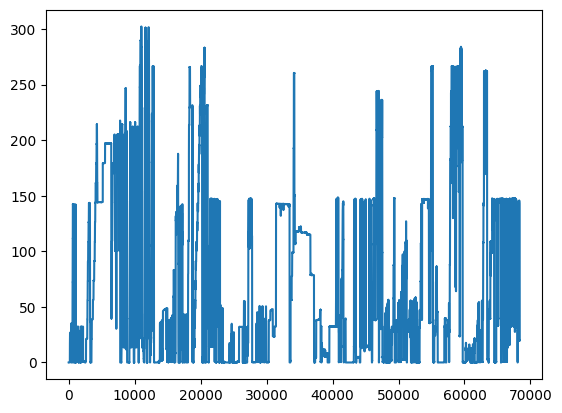

In [6]:
MeasurementData_Merged['Us'] = np.sqrt(MeasurementData_Merged['uDaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm']**2 + MeasurementData_Merged['uQaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm']**2)
MeasurementData_Merged['Us'].plot()

<Axes: >

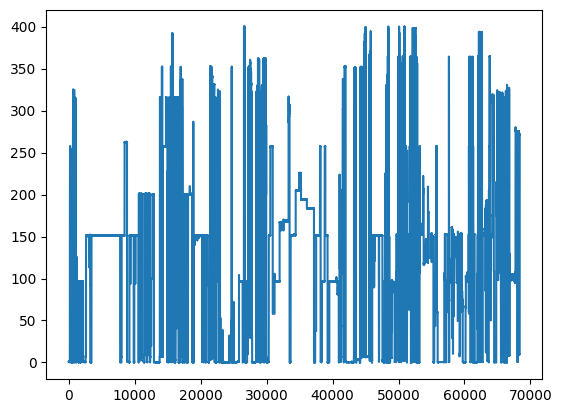

In [7]:
MeasurementData_Merged['Is'] = np.sqrt(MeasurementData_Merged['iDaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm']**2 + MeasurementData_Merged['iQaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm']**2)
MeasurementData_Merged['Is'].plot()

In [8]:
input_cols = ['nEmFild100ms.Rec_10ms_Fild.pp_rbe_CddAgEm_10ms_Fild.rbe_CddRslvr',
                'tqEmFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
                'iDaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm',
                'iQaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm',
                'uDaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
                'uQaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
                'R_CW_tCooltIvtrOut',
                'tEmSnsrFild10ms.Rec_2ms_Fild.rp_rbe_CddTEm_2ms_Fild.rbe_TMdlEm']

In [9]:
data = MeasurementData_Merged.copy()
data = data[data['pm'] <= 200]

In [10]:
data['profile_id']

0         1
1         1
2         1
3         1
4         1
         ..
68341    60
68342    60
68343    60
68344    60
68345    60
Name: profile_id, Length: 68345, dtype: int64

In [11]:
target_cols = ['pm','stator_winding','R_EM_tTMotRshaftOilIn']
temperature_cols = target_cols + ['tEmSnsrFild10ms.Rec_2ms_Fild.rp_rbe_CddTEm_2ms_Fild.rbe_TMdlEm','R_CW_tCooltIvtrOut']

In [12]:
test_profiles = [36, 37]
test_blacklist_profiles = [25]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles and p not in test_blacklist_profiles]
profile_sizes = data.groupby("profile_id").agg("size")
profile_sizes

profile_id
1      444
2      457
3      193
4     1447
5      825
6     4515
7     1238
8      745
9      745
10     827
11     455
12     445
13     355
14     295
15    1217
16    1581
17     227
18     641
19     633
20      14
21     728
22     849
23    2369
24    1071
25    1311
26     957
27     807
28    1021
29     419
30    1495
31     713
32     598
33     324
34    3603
35    3747
36     993
37    1127
38      78
39    1431
40     755
41     401
42     733
43    1285
44    1873
45    1045
46     729
47     907
48     953
49    1637
50     731
51     671
52    2661
53    1519
54     401
55    2555
56    2053
57    1791
58    1877
59    2533
60     295
dtype: int64

In [13]:
# normalize
non_temperature_cols = [c for c in data if c in input_cols and c not in temperature_cols]
data.loc[:, temperature_cols] /= 200  # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)
data.head()

,nEmFild100ms.Rec_10ms_Fild.pp_rbe_CddAgEm_10ms_Fild.rbe_CddRslvr,tqEmFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,frqSlipFild10ms.Rec_2ms_Fild.pp_rbe_MctAsm_2ms_Fild.rbe_MctAsm,iDaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm,iQaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm,uDaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,uQaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm,OilPmpCoolgSpdAct,OilPmpCoolgSpdReq,R_CW_vfCooltEm,...,I_EM_tTMotWinNdeLay2Cl12,I_EM_tTMotWinNdeLay5Cl03,I_EM_tTMotWinNdeLay5Cl12,Time,profile_id,profile_name,pm,stator_winding,Us,Is
0,0.0000,0.0,0.050290,0.003131,0.000157,0.0,0.000000e+00,2999.000000,3000.0,8.0,...,20.2,19.6,13.9,0.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...,0.112500,0.098875,0.000000,0.877229
1,-0.0001,0.0,-0.027593,0.002987,0.000000,0.0,-1.066800e-04,3002.000000,3000.0,8.0,...,20.2,19.6,13.9,0.675728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...,0.112500,0.098875,0.031250,0.834663
2,0.0000,0.0,0.009212,0.002684,0.000157,0.0,-1.963467e-08,3000.200958,3000.0,8.0,...,20.2,19.6,13.9,1.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...,0.112475,0.098875,0.000006,0.752600
3,0.0000,0.0,-0.046306,0.002908,0.000000,0.0,-5.742594e-08,3000.000000,3000.0,8.0,...,20.2,19.6,13.9,1.675728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...,0.112450,0.098875,0.000017,0.812500
4,0.0001,0.0,0.074648,0.002908,0.000213,0.0,0.000000e+00,3001.000000,3000.0,8.0,...,20.2,19.6,13.9,2.175728,1,20250602_112613_EFAD_Si_PS7_EF10_C2_RC02_TqEmM...,0.112475,0.098875,0.000000,0.816880


In [14]:
device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
data = data.loc[:, input_cols + ["profile_id"] + target_cols].dropna()
data.columns

Index(['nEmFild100ms.Rec_10ms_Fild.pp_rbe_CddAgEm_10ms_Fild.rbe_CddRslvr',
       'tqEmFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
       'iDaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm',
       'iQaFild10ms.Rec_2ms_Fild.rp_rbe_CddIPha_2ms_Fild.rbe_MctAsm',
       'uDaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
       'uQaFundaFild100ms.Rec_10ms_Fild.pp_rbe_Mct_10ms_Fild.rbe_MctAsm',
       'R_CW_tCooltIvtrOut',
       'tEmSnsrFild10ms.Rec_2ms_Fild.rp_rbe_CddTEm_2ms_Fild.rbe_TMdlEm',
       'profile_id', 'pm', 'stator_winding', 'R_EM_tTMotRshaftOilIn'],
      dtype='str')

In [16]:
def generate_tensor(profiles_list):
    """Returns profiles of the data set in a coherent 3D tensor with
    time-major shape (T, B, F) where
    T : Maximum profile length
    B : Batch size = Amount of profiles
    F : Amount of input features.

    Also returns a likewise-shaped sample_weights tensor, which zeros out post-padded zeros for use
    in the cost function (i.e., it acts as masking tensor)"""
    tensor = np.full(
        (profile_sizes[profiles_list].max(), len(profiles_list), data.shape[1] - 1),
        np.nan,
    )
    for i, (pid, df) in enumerate(
        data.loc[data.profile_id.isin(profiles_list), :].groupby("profile_id")
    ):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[: len(df), i, :] = df.drop(columns="profile_id").to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights

In [17]:
train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

In [18]:
p = Path(r'C:\20_Develop\10_Programming\60_thermal-nn\playground\data\20_Training_Sets\20_EACL')
p.mkdir(exist_ok=True, parents=False)

In [19]:
torch.save(train_tensor, p / "train_tensor.pt")
torch.save(train_sample_weights, p / "train_sample_weights.pt")
torch.save(test_tensor, p / "test_tensor.pt")
torch.save(test_sample_weights, p / "test_sample_weights.pt")

In [20]:
# Hyper parameters optimization 
# 自定义正弦激活层
class SinusLayer(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

In [21]:
def smooth_abs(x: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    return torch.sqrt(x**2 + epsilon)

In [22]:
# 激活函数映射
def get_activation(activation_name: str) -> nn.Module:
    activation_dict = {
        "Sigmoid": nn.Sigmoid(),
        "tanh": nn.Tanh(),
        "linear": nn.Identity(),
        "ReLU": nn.ReLU(),
        "biased Elu": nn.ELU(alpha=1.0),
        "sinus": SinusLayer()
    }
    return activation_dict[activation_name]

In [23]:
target_cols

['pm', 'stator_winding', 'R_EM_tTMotRshaftOilIn']

In [24]:
# TNNCell定义（支持动态结构和激活函数）
class TNNCell(nn.Module):
    def __init__(self, cond_net_layers, cond_net_units, cond_activations, 
                 ploss_net_layers, ploss_net_units, ploss_activations):
        super().__init__()
        self.sample_time = 0.5
        self.output_size = len(target_cols)
        self.caps = nn.Parameter(torch.Tensor(self.output_size))
        nn.init.normal_(self.caps, mean=-9.2, std=0.5)
        
        n_temps = len(temperature_cols) # number of temperatures (targets and input)
        n_conds = int(0.5 * n_temps * (n_temps - 1)) # number of thermal conductances

        # 动态构建conductance_net
        cond_layers = []
        input_dim = len(input_cols) + self.output_size
        for i, units in enumerate(cond_net_units):
            cond_layers.append(nn.Linear(input_dim, units))
            # 使用当前层的激活函数
            cond_layers.append(get_activation(cond_activations[i]))
            input_dim = units
        cond_layers.append(nn.Linear(input_dim, n_conds))
        cond_layers.append(nn.Sigmoid())
        self.conductance_net = nn.Sequential(*cond_layers)

        # 动态构建ploss_net
        ploss_layers = []
        input_dim = len(input_cols) + self.output_size
        for i, units in enumerate(ploss_net_units):
            ploss_layers.append(nn.Linear(input_dim, units))
            if i < len(ploss_net_units) - 1:
                ploss_layers.append(get_activation(ploss_activations[i]))
            input_dim = units
        ploss_layers.append(nn.Linear(input_dim, self.output_size))
        self.ploss = nn.Sequential(*ploss_layers)

        # 其余初始化代码
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = np.ones_like(self.adj_mat)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = torch.from_numpy(self.adj_mat[:self.output_size, :]).type(torch.int64)
        self.temp_idcs = [i for i, x in enumerate(input_cols) if x in temperature_cols]
        self.nontemp_idcs = [i for i, x in enumerate(input_cols) if x not in temperature_cols + ["profile_id"]]       

    def forward(self, inp: Tensor, hidden: Tensor) -> Tuple[Tensor, Tensor]:
        prev_out = hidden
        temps = torch.cat([prev_out, inp[:, self.temp_idcs]], dim=1)
        sub_nn_inp = torch.cat([inp, prev_out], dim=1)
        # conducts = torch.abs(self.conductance_net(sub_nn_inp))
        conducts = self.conductance_net(sub_nn_inp)
        # power_loss = torch.abs(self.ploss(sub_nn_inp))
        power_loss = smooth_abs(self.ploss(sub_nn_inp))
        temp_diffs = torch.sum(
            (temps.unsqueeze(1) - prev_out.unsqueeze(-1)) * conducts[:, self.adj_mat],
            dim=-1,
        )
        out = prev_out + self.sample_time * torch.exp(self.caps) * (temp_diffs + power_loss)
        return prev_out, torch.clip(out, -1, 5)  

In [25]:
# DiffEqLayer定义（支持TorchScript）
class DiffEqLayer(ScriptModule):
    def __init__(self, cell_module):
        super().__init__()
        self.cell = cell_module
        
    @script_method
    def forward(self, input: Tensor, state: Tensor) -> Tuple[Tensor, Tensor]:
        inputs = input.unbind(0)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs.append(out)
        return torch.stack(outputs), state

In [32]:
cond_net_layers = 3
cond_net_units = [20 for _ in range(cond_net_layers)]
cond_activations = ['ReLU' for _ in range(cond_net_layers)]
ploss_net_layers = 3
ploss_net_units = [20 for _ in range(ploss_net_layers)]
ploss_activations = ['ReLU' for _ in range(ploss_net_layers)]
tnn_cell = TNNCell(
    cond_net_layers, cond_net_units, cond_activations,  # 传递列表
    ploss_net_layers, ploss_net_units, ploss_activations  # 传递列表
).to(device)

model = DiffEqLayer(tnn_cell).to(device)
opt = optim.NAdam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction="none")
n_epochs = 200
tbptt_size = 512

with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        hidden = train_tensor[0, :, -len(target_cols):]
        n_batches = int(np.ceil(train_tensor.shape[0] / tbptt_size))

        for i in range(n_batches):
            opt.zero_grad()
            
            output, hidden = model(
                train_tensor[i*tbptt_size : (i+1)*tbptt_size, :, :len(input_cols)],
                hidden.detach().requires_grad_(True)
            )
            loss = loss_func(
                output,
                train_tensor[i*tbptt_size : (i+1)*tbptt_size, :, -len(target_cols):]
            )
            loss = (loss * train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :, None]).sum() 
            loss /= train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :].sum() + 1e-8  
            loss.backward()
            opt.step()
        # reduce learning rate
        if epoch == 150:
            for group in opt.param_groups:
                group["lr"] *= 0.5
        pbar.update()
        pbar.set_postfix_str(f"loss: {loss.item():.2e}")    

Training: 100%|██████████| 200/200 [07:41<00:00,  2.31s/it, loss: 4.33e-04]


In [33]:
# model saving and loading
mdl_path = Path.cwd() / 'data' / 'models'
mdl_path.mkdir(exist_ok=True, parents=True)
# mdl_file_path = mdl_path / 'tnn_jit_torch.pt'
mdl_file_path = mdl_path / 'tnn_jit_torch_STM_RTM_Oil_Joint_EFAD.pt'
# mdl_file_path = mdl_path / 'tnn_jit_torch_RTM_EFAD.pt'
model.save(mdl_file_path)  # save
model = torch.jit.load(mdl_file_path)  # load
model.eval()

RecursiveScriptModule(
  original_name=DiffEqLayer
  (cell): RecursiveScriptModule(
    original_name=TNNCell
    (conductance_net): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
      (3): RecursiveScriptModule(original_name=ReLU)
      (4): RecursiveScriptModule(original_name=Linear)
      (5): RecursiveScriptModule(original_name=ReLU)
      (6): RecursiveScriptModule(original_name=Linear)
      (7): RecursiveScriptModule(original_name=Sigmoid)
    )
    (ploss): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
      (3): RecursiveScriptModule(original_name=ReLU)
      (4): RecursiveScriptModule(original_name=Linear)
      (5): RecursiveScriptModule(o

In [35]:
# evaluate against test set
with torch.no_grad():
    pred, hidden = model(
        test_tensor[:, :, : len(input_cols)], test_tensor[0, :, -len(target_cols) :]
    )
    pred = pred.cpu().numpy() * 200  # denormalize

In [ ]:
import matplotlib.pyplot as plt

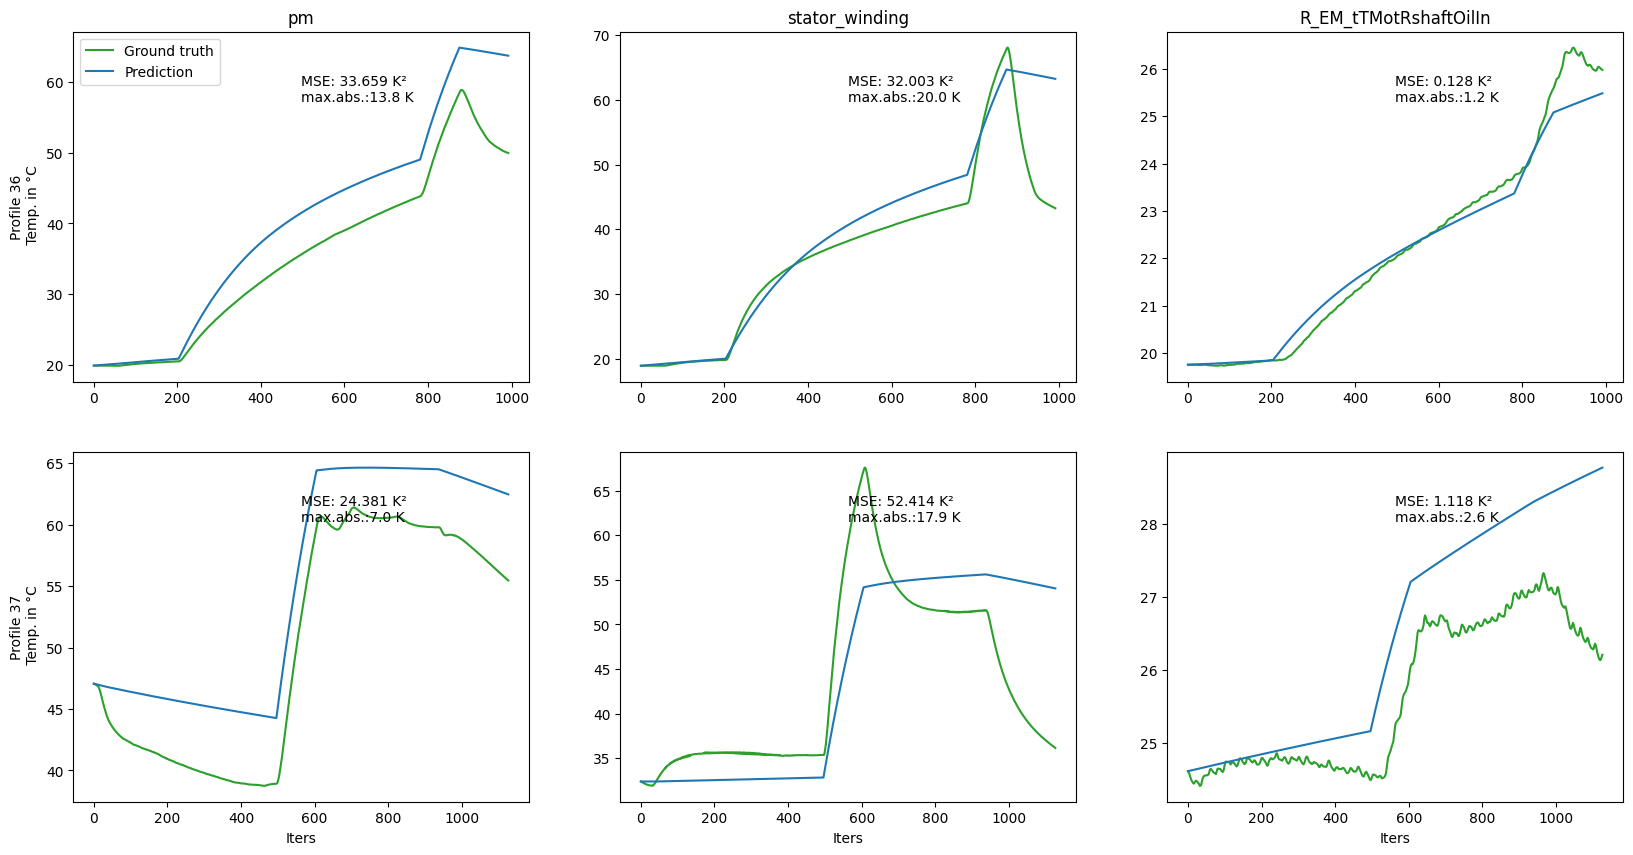

In [36]:
fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(
    data.loc[data.profile_id.isin(test_profiles), target_cols + ["profile_id"]].groupby(
        "profile_id"
    )
):
    y_test *= 200
    profile_pred = pred[: len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(
            y_test.loc[:, col].reset_index(drop=True),
            color="tab:green",
            label="Ground truth",
        )
        ax.plot(profile_pred[:, j], color="tab:blue", label="Prediction")
        ax.text(
            x=0.5,
            y=0.8,
            s=f"MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K",
            transform=ax.transAxes,
        )
        if j == 0:
            ax.set_ylabel(f"Profile {pid}\n Temp. in °C")
            if i == 0:
                ax.legend()
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f"Iters")
        elif i == 0:
            ax.set_title(col)